## Check the results on BXD data from all methods we have...

Objectives for this analysis:
1. Check the cases in which GEMMA may have performed badly...


2. For our current Bulkscan approach, even though it is fast, but theoretically it produces non-exact solutions. Thus, we need to: 
    - Check how different the Bulkscan results are compared with scan_alt results (assuming scan_alt gives the exact results)...
    
    - For those associations that are significant based on the exact solutions, can the Bulkscan solutions also find them?
    
3. Finally, we would explore the idea that combines finding the exact VC and the LiteQTL matrix multiplication approach, by grouping the traits with same or similar $h^2$ (from null) and perform matrix multiplication for each group (taken one group of multiple trait as a matrix).
    - Can this new idea beat bulkscan both in speed and accuracy?
   

### Preparation:

In [1]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
Threads.nthreads()

24

In [4]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [5]:
using LoopVectorization
using Tables
using Test
using Plots
using ThreadTools

In [6]:
include("../src/scan_LiteQTL.jl"); ## Load multithreaded functions to be tested:

In [7]:
include("../src/parallel_helpers.jl");

In [8]:
kinship_Gc = readdlm("run-gemma/output/kinship.cXX.txt", '\t');

In [9]:
kinship_Gc

79×79 Matrix{Float64}:
  0.971367    -0.0803409   0.118316    …  -0.219202    -0.174852
 -0.0803409    0.991482   -0.0287038       0.028784    -0.0582696
  0.118316    -0.0287038   1.01951        -0.12127     -0.114234
  0.0516335    0.0275875  -0.217635       -0.0696312   -0.165361
 -0.00965022  -0.141933   -0.103393        0.00610493  -0.0541761
 -0.0889471   -0.0646924   0.116334    …  -0.0353577    0.0386856
 -0.0566745    0.0206949   0.0738428      -0.0468544    0.028601
  0.057217     0.184047    0.00824396     -0.0485473   -0.0871337
  0.175272    -0.192295    0.0826458      -0.129463     0.0371489
 -0.139584     0.240522    0.0735055      -0.139098    -0.117519
 -0.0877774   -0.0840052  -0.0641144   …  -0.0366286    0.050524
 -0.0151781    0.122247    0.0683334      -0.0414448   -0.09087
  0.135896     0.0710691   0.0285863      -0.146292    -0.161624
  ⋮                                    ⋱               
 -0.00741148  -0.133136   -0.126767       -0.0603405    0.0356781
 -0.20

### Get full results:

(for all 35k BXD traits) from GEMMA and scan_alt()

In [9]:
function get_LODs_from_alt(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt (generic function with 1 method)

In [10]:
# @time results_from_alt = get_LODs_from_alt(pheno, geno, kinship_Gc; reml = false);

In [11]:
# writedlm("hsqs_from_alt.csv", results_from_alt[1], ',');

In [12]:
# writedlm("lods_from_alt.csv", results_from_alt[2], ',');

In [13]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64";

Read the saved output files...

In [14]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [15]:
@time pvals_from_gemma = CSV.File("output/pvals_from_gemma.csv", header = false) |> Tables.matrix;

 17.988128 seconds (27.61 M allocations: 7.684 GiB, 16.08% gc time, 12.55% compilation time)


In [10]:
@time hsqs_from_gemma = CSV.File("output/hsqs_from_gemma.csv", header = false) |> Tables.matrix;

 27.887673 seconds (57.58 M allocations: 9.209 GiB, 11.75% gc time, 60.97% compilation time)


In [11]:
@time lods_from_gemma = CSV.File("output/lods_from_gemma.csv", header = false) |> Tables.matrix;

 11.993454 seconds (22.23 M allocations: 7.389 GiB, 9.18% gc time, 0.09% compilation time)


In [13]:
size(lods_from_gemma)

(7321, 35556)

In [17]:
hsqs_from_gemma[6066, 108]

0.1839783

In [12]:
findfirst(isinf.(lods_from_gemma))

CartesianIndex(6066, 108)

In [16]:
sum(findall(isinf.(lods_from_gemma[6066, :])))

29128

In [19]:
lods_from_gemma[6061:6080, 108]

20-element Vector{Float64}:
  4.974971296497128
  5.642226041346928
  5.77407886098242
 10.773949486974042
 10.773949486974042
 Inf
 Inf
 Inf
 Inf
 Inf
 12.532501455149138
 12.532501455149138
 12.532501455149138
 12.532501455149138
 10.684385605968584
 10.684385605968584
  8.34154618961951
  8.34154618961951
  7.442655334047717
  7.442655334047717

In [20]:
lods_corrected = scan_perms(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; prior_a = 1.0, prior_b = 0.1, nperms = 0);

In [22]:
hcat(vec(lods_corrected)[6061:6080], lods_from_gemma[6061:6080, 108])

20×2 Matrix{Float64}:
  5.5787    4.97497
  6.0889    5.64223
  6.2897    5.77408
 11.8741   10.7739
 11.8741   10.7739
 21.0124   Inf
 21.0124   Inf
 19.9128   Inf
 19.9128   Inf
 19.9112   Inf
 11.6298   12.5325
 11.6298   12.5325
 11.6298   12.5325
 11.6298   12.5325
  9.57335  10.6844
  9.57335  10.6844
  7.89166   8.34155
  7.89166   8.34155
  7.095     7.44266
  7.095     7.44266

In [18]:
@time hsqs_from_alt = CSV.File("output/hsqs_from_alt.csv", header = false) |> Tables.matrix;

 12.571384 seconds (22.22 M allocations: 7.393 GiB, 27.55% gc time)


In [19]:
@time lods_from_alt = CSV.File("output/lods_from_alt.csv", header = false) |> Tables.matrix;

 12.881203 seconds (22.22 M allocations: 7.386 GiB, 33.08% gc time)


In [20]:
test = readdlm("run-gemma/output/gemma_results.txt.assoc.txt", '\t');

In [21]:
size(pvals_from_gemma) .== (p, m)

(true, true)

In [22]:
@testset "checkSavedResults" begin
    
    @test size(pvals_from_gemma, 1) == p && size(pvals_from_gemma, 2) == m;
    @test size(hsqs_from_gemma, 1) == p && size(hsqs_from_gemma, 2) == m;
    @test size(lods_from_alt, 1) == p && size(lods_from_alt, 2) == m;
    @test size(hsqs_from_alt, 1) == p && size(hsqs_from_alt, 2) == m;
    @test sum(hsqs_from_gemma[:, m] .== test[2:end, 9]) == p;
    @test sum(pvals_from_gemma[:, m] .== test[2:end, 10]) == p;
    
end;

Test Summary:     | Pass  Total
checkSavedResults |    6      6


### Compare results:

In [23]:
Threads.nthreads() # Number of julia threads using...

24

In [24]:
BLAS.get_num_threads() # Number of BLAS threads using...

8

In [25]:
BLAS.set_num_threads(24) # Number of BLAS threads using...

In [26]:
BLAS.get_num_threads() # Number of BLAS threads using...

24

In [27]:
grid_hsqs = collect(0:100).*0.01;

In [28]:
grid_hsqs = collect(0:10).*0.1;

In [29]:
@time lods_from_bulk = bulkscan(pheno, geno, kinship_Gc, grid_hsqs);

 11.812076 seconds (294.70 k allocations: 22.274 GiB, 18.22% gc time, 1.78% compilation time)


In [30]:
@time maxSqDiff(lods_from_bulk, lods_from_alt)

  1.078128 seconds (2 allocations: 1.939 GiB, 2.11% gc time)


7399.027333439694

In [31]:
any(lods_from_bulk .< 0)

false

In [32]:
any(lods_from_alt .< 0)

true

In [33]:
any(lods_from_gemma .< 0)

false

In [34]:
findmax(lods_from_bulk .- lods_from_alt)

(86.01759897509169, CartesianIndex(4753, 11077))

#### Compare bulkscan and scan_alt:

In [35]:
absDiff = abs.(lods_from_bulk .- lods_from_alt);
diffArray = vec(absDiff);

In [36]:
exactDiff = vec(lods_from_bulk .- lods_from_alt);

try hexbin...

Given a particular error tolerance, let's see how many the LOD scores estimated by our fast Bulkscan approach are within the acceptable error range:

### Check negativity issue in lods_from_alt:

We see from the above scatter plot, there are estimates of LOD scores that are negative, which is theoretically impossible. We now carefully examine how that happened in our outputs.

In [37]:
sum(lods_from_alt .< 0)/(m*p)

0.0007208108061468519

In [38]:
hasNegativeLODs = map(x -> any(lods_from_alt[:, x] .< 0), 1:m);
hasNegativeLODs_n1 = map(x -> any(lods_from_alt[:, x] .< -1.0), 1:m);

In [39]:
sum(hasNegativeLODs) # in total 386 (out of 35k) traits contain at least one negative LOD score.

386

In [40]:
sum(hasNegativeLODs_n1)

321

In [41]:
mean(hasNegativeLODs) # about 1% of the traits had negative LOD scores by scan_alt()

0.010856114298571268

Let's look at the first one...

In [42]:
blackSwans = findall(hasNegativeLODs); # traits that have at least one negative LOD

In [43]:
blackSwans_n1 = findall(hasNegativeLODs_n1); # traits that have at least one negative LOD

In [44]:
blackSwans

386-element Vector{Int64}:
    33
   108
   187
   222
   227
   258
   536
   544
   703
   712
   789
   821
   929
     ⋮
 34309
 34363
 34507
 34600
 34602
 34603
 34735
 34766
 35184
 35235
 35268
 35496

In [45]:
blackSwans_n1

321-element Vector{Int64}:
   108
   187
   222
   258
   536
   703
   712
   789
   929
   946
  1123
  1292
  1310
     ⋮
 34153
 34309
 34363
 34507
 34600
 34602
 34603
 34735
 34766
 35184
 35268
 35496

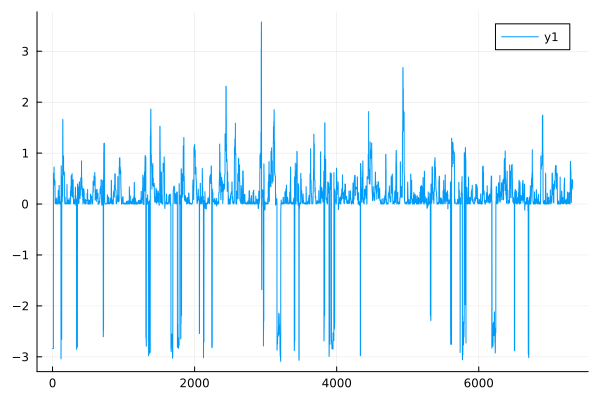

In [46]:
plot(lods_from_alt[:, 187])

In [47]:
test = scan_alt(reshape(pheno[:, 187], :, 1), geno, kinship_Gc; reml = false);

In [48]:
test[1]

0.132860815624458

In [49]:
test[2]

0.999999984947842

In [50]:
test[3]

7321-element Vector{Float64}:
 0.8993482584452811
 0.8993482584502311
 0.8993482581348059
 0.8993482581348059
 0.8993482414957287
 0.899348258420209
 0.8993482448879322
 0.8993482448879322
 0.8993482581348059
 0.8993482581348059
 0.8993482593459767
 0.8993616160814517
 0.999999984947842
 ⋮
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842
 0.999999984947842

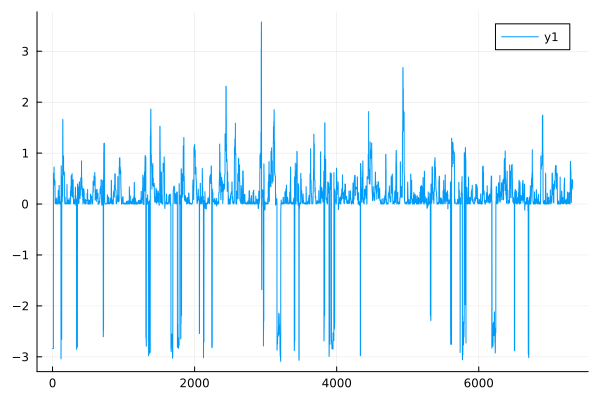

In [51]:
plot(scan_alt(reshape(pheno[:, 187], :, 1), geno, kinship_Gc; reml = false)[4])

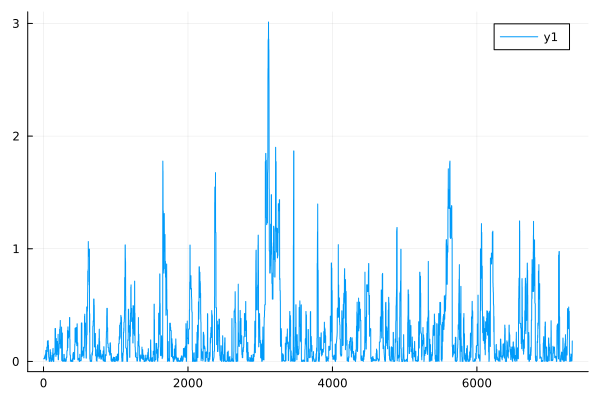

In [52]:
plot(lods_from_alt[:, 33])

In [53]:
firstBlackSwan = lods_from_alt[:, blackSwans[1]];

In [54]:
findall(firstBlackSwan .< 0)

4-element Vector{Int64}:
 853
 854
 855
 856

In [55]:
## Look at the corresponding hsqs:
map(x -> hsqs_from_alt[x, 33], findall(firstBlackSwan .< 0))

4-element Vector{Float64}:
 2.8889603743499245e-13
 2.8889603743499245e-13
 2.736462543444906e-13
 2.736462543444906e-13

In [56]:
bs_results_hsqs = Array{Array{Float64, 1}, 1}(undef, length(blackSwans));
bs_results_markers = Array{Array{Int, 1}, 1}(undef, length(blackSwans));
counter = 1;

for bs in blackSwans
    
    bs_lods = lods_from_alt[:, bs];
    bs_markers = findall(bs_lods .< 0);
    bs_hsqs = map(x -> hsqs_from_alt[x, bs], bs_markers);
    bs_results_hsqs[counter] = bs_hsqs;
    bs_results_markers[counter] = bs_markers;
    counter = counter + 1;
    
end

In [57]:
vec_bs_results_hsqs = [];
for x in bs_results_hsqs
    vec_bs_results_hsqs = vcat(vec_bs_results_hsqs, x);
end

In [58]:
vec_bs_results_markers = [];
for x in bs_results_markers
    vec_bs_results_markers = vcat(vec_bs_results_markers, x);
end

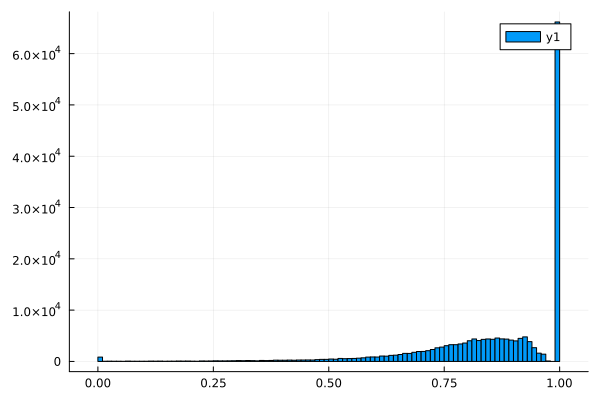

In [59]:
histogram(vec_bs_results_hsqs)

In [60]:
test_lods_K = scan_alt(reshape(pheno[:, 33], :, 1), geno, kinship; reml = false)[4];

In [61]:
test_lods_KGc = scan_alt(reshape(pheno[:, 33], :, 1), geno, kinship_Gc; reml = false)[4];

In [62]:
sumSqDiff(reshape(test_lods_KGc, :, 1), reshape(test_lods_K, :, 1))

1.2994834494907659

In [63]:
any(test_lods_KGc .< 0)

false

In [64]:
any(test_lods_K .< 0)

true

In [65]:
sumSqDiff(reshape(test_lods_KGc, :, 1), reshape(lods_from_alt[:, 33], :, 1))

1.8515786307649385e-24

In [66]:
sumSqDiff(reshape(test_lods_K, :, 1), reshape(lods_from_alt[:, 33], :, 1))

1.2994834494901637

In [67]:
any(lods_from_alt[:, 33] .< 0)

true

In [68]:
bs_results_hsqs[1]

4-element Vector{Float64}:
 2.8889603743499245e-13
 2.8889603743499245e-13
 2.736462543444906e-13
 2.736462543444906e-13

In [69]:
bs_results_markers[1]

4-element Vector{Int64}:
 853
 854
 855
 856

In [70]:
test_lods_K[856]

-6.1716957859410366e-15

But, are they all very small (negative but very close to 0)?

In [71]:
negativeLods = [];

for j in 1:p
    for i in 1:m
        if lods_from_alt[j, i] < 0
            append!(negativeLods, lods_from_alt[j, i]);
        else
            continue;
        end
    end
end     

In [72]:
negativeLods_n1 = [];

for j in 1:p
    for i in 1:m
        if lods_from_alt[j, i] < -1.0
            append!(negativeLods_n1, lods_from_alt[j, i]);
        else
            continue;
        end
    end
end  

In [73]:
length(negativeLods)

187631

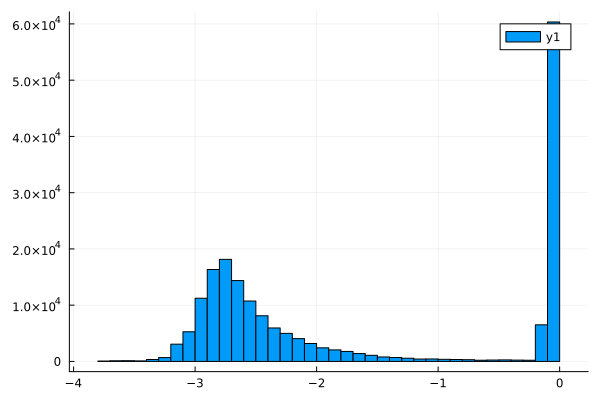

In [74]:
histogram(negativeLods)

In [75]:
negativeLods

187631-element Vector{Any}:
 -2.8364198415233637
 -2.3218522154526453
 -2.7159556629889297
 -2.1721973365984493
 -2.264965511150842
 -2.542476243814359
 -2.710494876228621
 -1.1697774413762279
 -2.7938726506943405
 -1.8205130845275086
 -2.293762921721445
 -2.6860082921356594
 -2.9593111257339486
  ⋮
 -0.007686738723658984
 -0.04020926181499682
 -2.562435531364291
 -2.967028433905106
 -2.8673702255188362
 -0.09970799532808765
 -0.05420349375631247
 -0.015245481757609283
 -0.1436970021656976
 -0.014311908993334564
 -2.458421773014684
 -0.02427366860169513

In [76]:
sum(negativeLods .< -1)/(p*m)

0.0004554802373807918

In [77]:
findfirst(lods_from_alt .< -1.0)

CartesianIndex(229, 108)

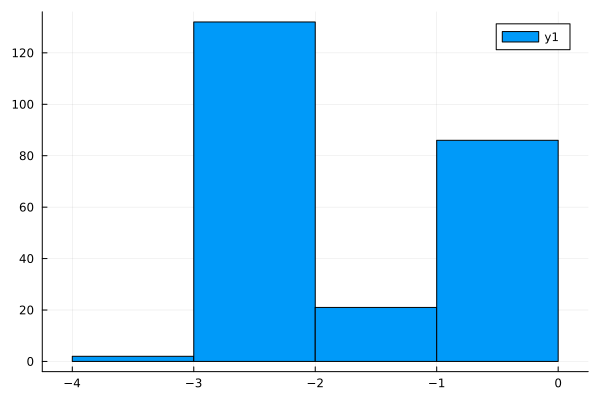

In [78]:
histogram(lods_from_alt[lods_from_alt[:, 108] .< 0, 108])

In [79]:
tol = 1.0;

In [80]:
sum(diffArray .<= tol)/length(diffArray)

0.9884312114893811

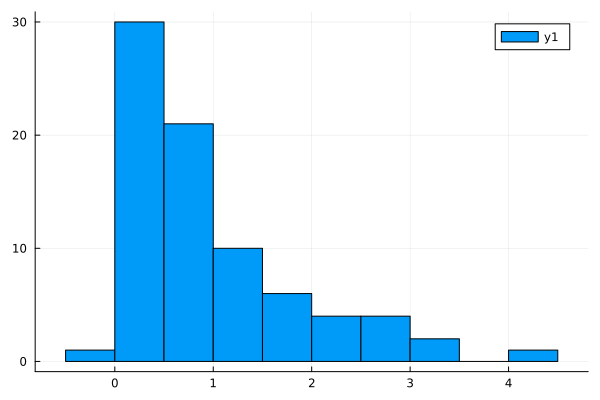

In [81]:
histogram(eigen(kinship_Gc).values)

In [82]:
test[4] # from scan_alt(kinship_Gc)

7321-element Vector{Float64}:
 -2.836419834316946
 -2.836419834316952
 -2.836419834316952
 -2.836419834316952
 -2.836419834316952
 -2.836419834316946
 -2.836419834316946
 -2.836419834316946
 -2.836419834316952
 -2.836419834316952
 -2.836419833599363
 -2.8364120623679985
  0.6033791659636699
  ⋮
  0.30170431232257705
  0.30170431266924735
  0.30170431266924735
  0.3719390973072517
  0.2909953718521782
  0.2909953718521782
  0.48298676948780855
  0.4066473087217643
  0.4152662994368362
  0.32721674326049227
  0.4661009363208286
  0.4661009363208286

In [83]:
test_bulk = scan_alt(reshape(pheno[:, 108], :, 1), geno, kinship; reml = false);

In [84]:
kinship

79×79 Matrix{Float64}:
 1.0       0.468763  0.561085  0.521296  …  0.567302  0.413471  0.435604
 0.468763  1.0       0.482652  0.50435      0.519167  0.532541  0.488972
 0.561085  0.482652  1.0       0.374733     0.622687  0.450508  0.453984
 0.521296  0.50435   0.374733  1.0          0.431956  0.469879  0.421972
 0.502617  0.431553  0.443817  0.577574     0.494489  0.51971   0.489528
 0.476443  0.483647  0.567154  0.462847  …  0.491136  0.512453  0.549432
 0.467349  0.501111  0.520678  0.527738     0.527077  0.481474  0.51916
 0.542558  0.60105   0.506142  0.463404     0.554531  0.498891  0.479556
 0.591896  0.403189  0.533654  0.425491     0.543941  0.448744  0.532008
 0.441302  0.626432  0.535918  0.447991     0.551656  0.450761  0.461508
 0.460209  0.457172  0.460111  0.489766  …  0.493009  0.494999  0.538533
 0.507042  0.570832  0.536868  0.614983     0.499858  0.503124  0.478369
 0.582008  0.544672  0.516424  0.492132     0.452945  0.45013   0.442422
 ⋮                           

#### Try if bounded fitlmm() will solve the problem:

In [85]:
pheno_108 = reshape(pheno[:, 108], :, 1);

In [86]:
(y0_108, X0, lambda0) = rotateData(pheno_108, hcat(ones(n), geno), kinship_Gc);

In [87]:
var(y0_108)

38.406684578131774

In [88]:
var(pheno; dims = 1)

1×35556 Matrix{Float64}:
 0.0316942  0.0560302  0.0589198  …  0.0218381  0.0102334  0.00947539

In [89]:
function scan_alt_re(y::Array{Float64,2},g::Array{Float64,2}, K::Array{Float64,2}; 
                  reml::Bool = false)

    # number of markers
    (n, p) = size(g)
    # make intercept
    intercept = ones(n, 1)
    # rotate data
    (y0, X0, lambda0) = rotateData(y, [intercept g], K)

    pve_list = Array{Float64, 1}(undef, p);

    X00 = reshape(X0[:, 1], :, 1)
    # fit null lmm
    out00 = fitlmm(y0, X00, lambda0; reml = reml);

    lod = zeros(p)
    
    for i = 1:p
        
        X = hcat(X0[:, 1], X0[:, i+1]);
        
        out11 = fitlmm(y0, X, lambda0; reml = reml);

        pve_list[i] = out11.h2;

        lod[i] = (out11.ell - out00.ell)/log(10)
    end

    return (out00.sigma2, out00.h2, pve_list, lod)

end

scan_alt_re (generic function with 1 method)

In [90]:
test1 = scan_alt_re(pheno_108, geno, kinship; reml = false);

In [91]:
test2 = scan_alt_re(pheno_108, geno, kinship_Gc; reml = false);

In [92]:
maximum(test1[3])

0.9825411002339195

In [93]:
test1[3][229]

0.7748315793772295

In [94]:
summary_108 = vcat(hcat("kinship", "kinship_Gc"), hcat(test1[3][229], test2[3][229]), hcat(test1[4][229], test2[4][229]));
hcat(["", "hsq", "lod"], summary_108)

3×3 Matrix{Any}:
 ""      "kinship"    "kinship_Gc"
 "hsq"  0.774832     0.833613
 "lod"  1.05873     -2.2873

In [95]:
test2[3][229]

0.8336134482066376

In [96]:
intercept = ones(n, 1);

In [97]:
(y1, X1, lambda1) = rotateData(pheno_108, hcat(intercept, geno), kinship); 
(y2, X2, lambda2) = rotateData(pheno_108, hcat(intercept, geno), kinship_Gc);

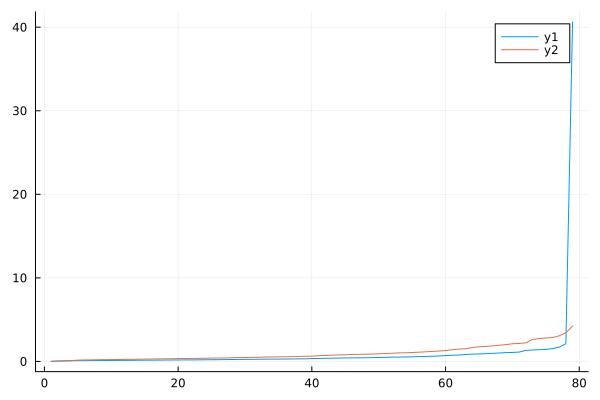

In [98]:
plot(lambda1)
plot!(lambda2)

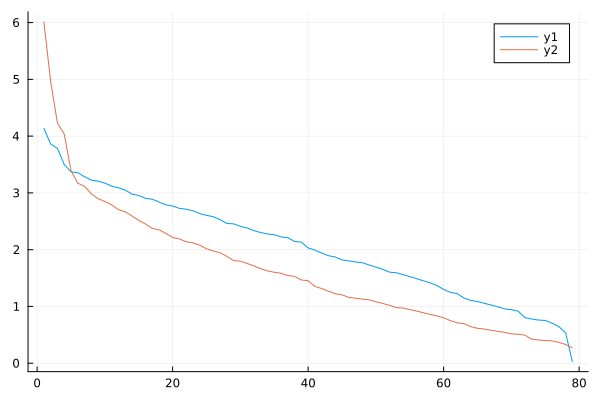

In [99]:
w1 = makeweights(test1[3][229], lambda1);
w2 = makeweights(test2[3][229], lambda2);

plot(w1)
plot!(w2)

In [100]:
est2_h0 = fitlmm(y2, reshape(X2[:, 1], :, 1), lambda2);
est2_h1 = fitlmm(y2, hcat(X2[:, 1], X2[:, 230]), lambda2);

In [101]:
(est2_h1.ell - est2_h0.ell)/log(10)

-2.287303632407237

In [102]:
lods_from_gemma[229, 108] # from GEMMA; we should get

0.7365456112208408

In [103]:
scan_alt(pheno_108, geno, kinship_Gc)[4][229]

-2.287303632407237

In [104]:
function wls_bayes(y::Array{Float64, 2}, X::Array{Float64, 2}, w::Array{Float64, 1}, prior::Array{Float64, 1};
             reml::Bool = false, loglik::Bool = true, method = "qr")

    (n, p) = size(X); # get number of observations and the number of markers from geno dimensions      

    n = size(y, 1); # get number of observations       

    # check if weights are positive
    if(any(w .<= .0))
        error("Some weights are not positive.")
    end

    # square root of the weights
    sqrtw = sqrt.(w)

    # logdetXtX = logdet(X' * X); constant term that does not depend on the parameters (weights); is not needed

    # scale by weights
    yy = rowMultiply(y, sqrtw)
    XX = rowMultiply(X, sqrtw)

    # least squares solution
    # faster but numerically less stable
    if(method == "cholesky")
        fct = cholesky(XX'XX)
        b = fct\(XX'yy)
        logdetXXtXX = logdet(fct)
    end

    # slower but numerically more stable
    if(method == "qr")
        fct = qr(XX)
        b = fct\yy

        # logdetXXtXX = 2*logdet(fct.R) # need 2 for logdet(X'X)
        # logdetXXtXX = logdet(fct.R' * fct.R);
        logdetXXtXX = 2*logabsdet(fct.R)[1];

    end

    yyhat = XX*b
    rss0 = sum((yy-yyhat).^2)

    if(reml)
        sigma2 = rss0/(n-p)
    else
        sigma2 = (rss0+prior[1]*prior[2])/(n+prior[2])
    end

    # see formulas (2) and (3) of Kang (2008)
    if(loglik)

        # ell = -0.5 * ( n*log(sigma2) + sum(log.(w)) + rss0/sigma2 )
        # ell = -0.5 * (n*log(sigma2) - sum(log.(w)) + rss0/sigma2)
        ell = -0.5 * ((n+prior[2])*log(sigma2) - sum(log.(w)) + (rss0+prior[1]*prior[2])/sigma2)

        if(reml)
            # ell = ell + 0.5 * (p*log(2pi*sigma2) + logdetXtX - logdetXXtXX) # full log-likelihood including the constant terms;
            ell = ell + 0.5 * (p*log(sigma2) - logdetXXtXX)
        end
        
    else
        ell = missing;
    end

    return LSEstimates(b, sigma2, ell)

end

wls_bayes (generic function with 1 method)

In [105]:
function makeweights(h2::Float64, lambda::Array{Float64,1})

    vars = h2*lambda .+ (1.0-h2)
    return 1.0./vars

end

makeweights (generic function with 1 method)

In [106]:
function makeweights_repara(h2::Float64, lambda::Array{Float64,1})

    delta = h2/(1-h2);
    vars = (delta.*lambda .+ 1);
    return 1.0./vars

end

makeweights_repara (generic function with 1 method)

In [107]:
hcat(makeweights(0.99, lambda0), makeweights_repara(0.99, lambda0))

79×2 Matrix{Float64}:
 100.0       1.0
  19.2965    0.192965
  10.7249    0.107249
   9.36438   0.0936438
   6.15791   0.0615791
   5.35278   0.0535278
   5.1644    0.051644
   4.75213   0.0475213
   4.50099   0.0450099
   4.3622    0.043622
   4.19871   0.0419871
   3.9784    0.039784
   3.87993   0.0387993
   ⋮         
   0.519658  0.00519658
   0.499658  0.00499658
   0.475156  0.00475156
   0.467243  0.00467243
   0.451079  0.00451079
   0.382809  0.00382809
   0.368365  0.00368365
   0.357798  0.00357798
   0.353566  0.00353566
   0.328263  0.00328263
   0.294727  0.00294727
   0.237859  0.00237859

In [108]:
function fitlmm_Bdd(y::Array{Float64, 2}, X::Array{Float64, 2}, lambda::Array{Float64, 1};
                reml::Bool = false, loglik::Bool = true, h20::Float64 = 0.5, d::Float64 = 1.0)
    prior = [var(vec(y)), 1/100];
    function logLik0(h2::Float64)
        out = wls_bayes(y, X, makeweights_repara(h2, lambda), prior; reml = reml, loglik = loglik)
        return -out.ell
    end
    ## avoid the use of global variable in inner function;

    opt = optimize(logLik0, max(h20-d, 0.0), min(h20+d, 1.0))
    # opt = optimize(logLik0, max(h20-d, 0.0), min(h20+d, 1.0))
    h2 = opt.minimizer
    est = wls_bayes(y, X, makeweights_repara(h2, lambda), prior; reml = reml, loglik = loglik)
    return LMMEstimates(est.b, est.sigma2, h2, est.ell)
end

fitlmm_Bdd (generic function with 1 method)

In [109]:
test_null = fitlmm_Bdd(y0_108, X0_intercept, lambda0; reml = false);

LoadError: UndefVarError: X0_intercept not defined

In [110]:
test_null.h2

LoadError: UndefVarError: test_null not defined

In [111]:
prior = [var(vec(y0_108)), 1/100]

2-element Vector{Float64}:
 38.406684578131774
  0.01

In [112]:
wls_bayes(y0_108, X0_intercept, makeweights_repara(0.99, lambda0), prior; reml = false).ell

LoadError: UndefVarError: X0_intercept not defined

In [113]:
wls_bayes(y0_108, X0_intercept, makeweights_repara(0.794, lambda0), prior; reml = false).ell

LoadError: UndefVarError: X0_intercept not defined

In [114]:
function get_LODs_from_alt_SVD_Bdd(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData_SVD(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm_Bdd(y0_i, intercept0, lambda0; reml = reml);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm_Bdd(y0_i, X, lambda0; reml = reml);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt_SVD_Bdd (generic function with 1 method)

In [115]:
test_unbounded = get_LODs_from_alt_SVD(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; reml = false);

LoadError: UndefVarError: get_LODs_from_alt_SVD not defined

In [116]:
test_bounded = get_LODs_from_alt_SVD_Bdd(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; reml = false);

LoadError: UndefVarError: rotateData_SVD not defined

In [117]:
test_unbounded[2][229]

LoadError: UndefVarError: test_unbounded not defined

In [118]:
test_bounded[2][229]

LoadError: UndefVarError: test_bounded not defined

In [119]:
lods_from_gemma[229, 108] # from gemma

0.7365456112208408

In [120]:
sumSqDiff(reshape(test_unbounded[2], :, 1), reshape(test_bounded[2], :, 1))

LoadError: UndefVarError: test_unbounded not defined

In [121]:
hcat(test_unbounded[2], test_bounded[2], lods_from_bulk[:, 108], lods_from_gemma[:, 108])

LoadError: UndefVarError: test_unbounded not defined

In [122]:
test_unbounded = get_LODs_from_alt_SVD(reshape(pheno[:, 109], :, 1), geno, kinship_Gc; reml = false);

LoadError: UndefVarError: get_LODs_from_alt_SVD not defined

In [123]:
test_bounded = get_LODs_from_alt_SVD_Bdd(reshape(pheno[:, 109], :, 1), geno, kinship_Gc; reml = false);

LoadError: UndefVarError: rotateData_SVD not defined

In [124]:
hcat(test_unbounded[2], test_bounded[2], lods_from_bulk[:, 109], lods_from_gemma[:, 109])

LoadError: UndefVarError: test_unbounded not defined

In [125]:
hasNega = lods_from_alt[:, 108] .>= 0;
isFin = isfinite.(lods_from_gemma[:, 108]);
sum(hasNega .* isFin)

7075

In [126]:
plot(test_unbounded[2], color = "blue", label = "unbounded hsq")
plot!(test_bounded[2], color = "red", label = "bounded hsq by 0.99")

LoadError: UndefVarError: test_unbounded not defined

In [127]:
findall(test_unbounded[2].<= 0)

LoadError: UndefVarError: test_unbounded not defined

In [128]:
findall(test_bounded[2].<= 0)

LoadError: UndefVarError: test_bounded not defined

In [129]:
minimum(test_bounded[2])

LoadError: UndefVarError: test_bounded not defined

In [130]:
maximum(test_bounded[2])

LoadError: UndefVarError: test_bounded not defined

In [131]:
maximum(lods_from_bulk[:, 108])

26.215395995293537

In [132]:
maximum(lods_from_gemma[:, 108])

Inf

#### Check loglikelihoods:

if(loglik)

        ell = -0.5 * (n*log(sigma2) - sum(log.(w)) + rss0/sigma2)

        if(reml)
            # ell = ell + 0.5 * (p*log(2pi*sigma2) + logdetXtX - logdetXXtXX) # full log-likelihood including the constant terms;
            ell = ell + 0.5 * (p*log(sigma2) - logdetXXtXX)
        end
        
    else
        ell = missing;
end

In [133]:
test_weights = reduce(hcat, map(x -> makeweights_repara(x, round.(lambda0, digits = 4)), collect(0.0:0.01:0.99)));
test_sumlogw = mapslices(x -> sum(log.(x)), test_weights; dims = 1);

In [134]:
size(test_weights)

(79, 100)

In [135]:
prior = [var(y0_108), 1/100];

In [136]:
test_estimates = mapslices(x -> wls_bayes(y0_108, hcat(X0_intercept, X0_covar[:, 229]), x, [var(y0_108), 1/100]).ell, test_weights; dims = 1); 

LoadError: UndefVarError: X0_covar not defined

In [137]:
test_estimates_null = mapslices(x -> wls_bayes(y0_108, X0_intercept, x, prior).ell, test_weights; dims = 1); 

LoadError: UndefVarError: X0_intercept not defined

In [138]:
hsqs_from_alt[229, 108]

0.8336134482039249

In [139]:
function delta2hsq(delta::Float64)
    
    return delta/(1+delta);
    
end

function hsq2delta(hsq::Float64)
    
    return hsq/(1-hsq);
    
end

hsq2delta (generic function with 1 method)

In [140]:
test_weights_delta = reduce(hcat, map(x -> makeweights_repara(x, round.(lambda_EF[3], digits = 4)), delta2hsq.(exp.(collect(-10:1:10)))));
test_sumlogw_delta = mapslices(x -> sum(log.(x)), test_weights_delta; dims = 1);

LoadError: UndefVarError: lambda_EF not defined

In [141]:
test_estimates_delta = mapslices(x -> wls_bayes(y0_108, hcat(X0_intercept, X0_covar[:, 229]), x, prior).ell, test_weights_delta; dims = 1); 

LoadError: UndefVarError: test_weights_delta not defined

In [142]:
test_estimates_delta_null = mapslices(x -> wls_bayes(y0_108, X0_intercept, x, prior).ell, test_weights_delta; dims = 1); 

LoadError: UndefVarError: test_weights_delta not defined

In [143]:
fitlmm(y0_108, X0_intercept, lambda0).h2

LoadError: UndefVarError: X0_intercept not defined

In [144]:
fitlmm_Bdd(y0_108, X0_intercept, lambda0).h2 # null

LoadError: UndefVarError: X0_intercept not defined

In [145]:
fitlmm_Bdd(y0_108, X0_intercept, lambda0).ell # null 

LoadError: UndefVarError: X0_intercept not defined

In [146]:
fitlmm_Bdd(y0_108, hcat(X0_intercept, X0_covar[:, 229]), lambda0).h2 # alt (marker 229)

LoadError: UndefVarError: X0_covar not defined

In [147]:
fitlmm_Bdd(y0_108, hcat(X0_intercept, X0_covar[:, 229]), lambda0).ell # alt (marker 229)

LoadError: UndefVarError: X0_covar not defined

In [148]:
(-52.636648457206405+54.452988649231926)/log(10)

0.7888265226557766

In [149]:
lods_from_gemma[229, 108]

0.7365456112208408

In [150]:
plot(vec(test_estimates), label = "loglik_H229")
plot!(vec(test_estimates_null), label = "loglik_H0")
# plot!(vec(0.5*test_sumlogw), label = "loglik_from_W")
# scatter!(1000*[hsqs_from_alt[229, 108]], [-52.6], label = false)
# scatter!(1000*[0.794], [-55.40097526019391], label = false)


LoadError: UndefVarError: test_estimates not defined

In [151]:
plot(collect(-10:1:10), vec(test_estimates_delta), label = "loglik_H229", xlabel = "log(delta)")
plot!(collect(-10:1:10), vec(test_estimates_delta_null), label = "loglik_H0")
scatter!([log(hsq2delta(hsqs_from_alt[229, 108]))], [-52.6], label = "Brent's maximum")
scatter!([log(hsq2delta(0.9797566649597435))], [-54.452988649231926], label = "Brent's maximum")

LoadError: UndefVarError: test_estimates_delta not defined

In [152]:
exp(10)

22026.465794806718

In [153]:
lods_from_gemma[108, 229]

0.20150452029208724

In [154]:
lods_from_bulk[108, 229]

0.3416645173063484

In [155]:
test = get_LODs_from_alt_SVD_Bdd(reshape(pheno[:, 108], :, 1), geno, kinship_Gc; reml = false)[2];

LoadError: UndefVarError: rotateData_SVD not defined

In [156]:
test[229]

LoadError: BoundsError: attempt to access Tuple{Float64, Float64, Vector{Float64}, Vector{Float64}} at index [229]

In [157]:
lods_from_bulk[229, 108]

1.1926195665513668

In [158]:
lods_from_gemma[229, 108]

0.7365456112208408

In [159]:
function get_LODs_from_alt_SVD_Bdd(Y::Array{Float64, 2}, G::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false, d::Float64 = 0.0)

    (n, m) = size(Y);
    p = size(G, 2);
    
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, X0, lambda0) = rotateData_SVD(Y, [intercept G], K);
    
    lods_from_alt = Array{Float64, 2}(undef, p, m);
    hsqs_from_alt = Array{Float64, 2}(undef, p, m);

    intercept0 = reshape(X0[:, 1], :, 1);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm_Bdd(y0_i, intercept0, lambda0; reml = reml, d = d);
        
        lod = zeros(p);
        hsqs = zeros(p);
        X = zeros(n, 2);
        X[:, 1] = X0[:, 1];
        
        for j in 1:p
            X[:, 2] = X0[:, j+1];
            
            out11 = fitlmm_Bdd(y0_i, X, lambda0; reml = reml, d = d);
            
            hsqs[j] = out11.h2;
            lod[j] = (out11.ell - out00.ell)/log(10);
            
        end
        
        lods_from_alt[:, i] = lod;
        hsqs_from_alt[:, i] = hsqs;
        
    end
    
    return (hsqs_from_alt, lods_from_alt);
    
end

get_LODs_from_alt_SVD_Bdd (generic function with 1 method)

#### Compare bulkscan and gemma:

Let's first convert the GEMMA logP to LOD scores:

In [1]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogccdf(Chisq(df), log(pval))
    lod = lrs/(2*log(10))
    
    # return lrs
    return lod

end

p2lod (generic function with 1 method)

In [161]:
# @time lods_from_gemma = tmap(x -> p2lod(x, 1), pvals_from_gemma);

In [162]:
pwd()

"/home/zyu20/git/BulkLMM.jl/test"

In [163]:
# @time writedlm("output/lods_from_gemma.csv", lods_from_gemma, ',');

In [164]:
function checkNaNTraits(L::Array{Float64, 2})
    
    hasNaN = mapslices(x -> any(isnan.(x)), L, dims = 1);
    return hasNaN;
    
end

checkNaNTraits (generic function with 1 method)

In [165]:
hasNaN = checkNaNTraits(lods_from_gemma)

1×35556 Matrix{Bool}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0

In [166]:
m - sum(hasNaN)

31923

In [167]:
sum(isnan.(lods_from_bulk))

0

In [168]:
sub_L_gemma = lods_from_gemma[:, .!vec(test)]

LoadError: MethodError: no method matching vec(::Tuple{Float64, Float64, Vector{Float64}, Vector{Float64}})
[0mClosest candidates are:
[0m  vec([91m::Transpose{<:Number, <:AbstractVector}[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:215
[0m  vec([91m::Adjoint{<:Real, <:AbstractVector}[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:216
[0m  vec([91m::SparseArrays.AbstractSparseVector[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/SparseArrays/src/sparsevector.jl:964
[0m  ...

In [169]:
sub_L_bulk = lods_from_bulk[:, .!vec(test)];

LoadError: MethodError: no method matching vec(::Tuple{Float64, Float64, Vector{Float64}, Vector{Float64}})
[0mClosest candidates are:
[0m  vec([91m::Transpose{<:Number, <:AbstractVector}[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:215
[0m  vec([91m::Adjoint{<:Real, <:AbstractVector}[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/adjtrans.jl:216
[0m  vec([91m::SparseArrays.AbstractSparseVector[39m) at ~/Softwares/Julia/julia-1.7.3/share/julia/stdlib/v1.7/SparseArrays/src/sparsevector.jl:964
[0m  ...

In [170]:
any(isnan.(sub_L_gemma))

LoadError: UndefVarError: sub_L_gemma not defined

In [171]:
any(isnan.(absDiff_withGemma))

LoadError: UndefVarError: absDiff_withGemma not defined

In [172]:
absDiff_withGemma = abs.(sub_L_bulk .- sub_L_gemma);
diffArray_withGemma = vec(absDiff_withGemma);

LoadError: UndefVarError: sub_L_bulk not defined

In [173]:
quantile(diffArray_withGemma)

LoadError: UndefVarError: diffArray_withGemma not defined

In [174]:
histogram(diffArray_withGemma, binwidth = 1.0)

LoadError: UndefVarError: diffArray_withGemma not defined

In [175]:
sum(diffArray_withGemma .<= tol)/length(diffArray_withGemma)

LoadError: UndefVarError: diffArray_withGemma not defined

## Explore the binning idea:

### Compute null hsqs for every trait:

In [176]:
BLAS.set_num_threads(1)

In [177]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = true)

    (n, m) = size(Y);
    intercept = reshape(ones(n, 1), :, 1);
    (Y0, intercept0, lambda0) = rotateData(Y, intercept, K);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0; reml = reml);
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [178]:
@time hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = true);

  7.873800 seconds (31.89 M allocations: 12.694 GiB, 16.24% gc time)


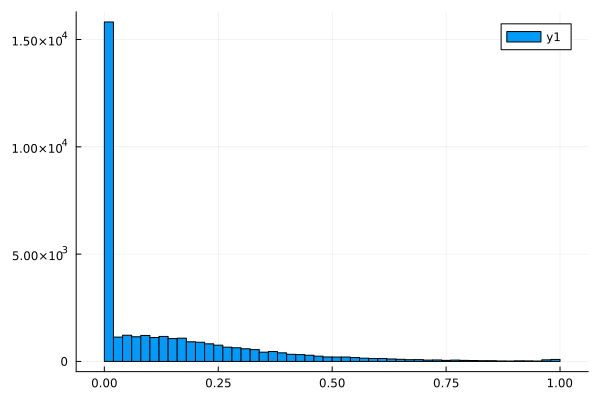

In [179]:
histogram(hsqs_from_null)

In [180]:
findall(hsqs_from_null .> 0.90)

239-element Vector{Int64}:
   536
   712
  1292
  1558
  1634
  2571
  2886
  3069
  3268
  3403
  3446
  3745
  3950
     ⋮
 32890
 32955
 33026
 33160
 33310
 33458
 34153
 34344
 34507
 34735
 34766
 35268

In [181]:
hsqs_from_null[7919]

0.8182834272313365

In [182]:
function groupTraits(m::Int64, listHsq::Array{Float64, 1}, quantileHsq::Array{Float64, 2})
    
    
    
    
end

groupTraits (generic function with 1 method)